In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model

## Loading an image (just for example)

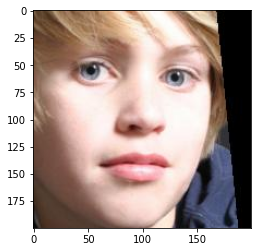

In [2]:
SAMPLE_PATH = '../input/utkface-new/UTKFace/'\
                '10_0_0_20170110220111082.jpg.chip.jpg'
dummy_img = cv2.imread(SAMPLE_PATH)
dummy_img = cv2.cvtColor(dummy_img, cv2.COLOR_BGR2RGB)
plt.imshow(dummy_img)

 ## Finding the number of files in the dataset
 We are going to take the data from UTKFace folder.

In [3]:
print(len(os.listdir('../input/utkface-new/UTKFace')))
print(len(os.listdir('../input/utkface-new/crop_part1')))

23708
9780


A file name in the dataset (age_gender_race).
- age: integer from 0 to 116
- gender: 0 (male), 1 (female)
- race: 0 (white), 1 (black), 2 (asian), 3 (indian), 4 (others)

## Function for taking labels

In [4]:
def take_targets(filename):
    targets = filename.split('_')
    age = targets[0]
    gender = targets[1]
    race = targets[2]
    
    return age, gender, race

## Function for loading images

In [5]:
PATH = '../input/utkface-new/UTKFace/'

def load_images(path):
    files = os.listdir(path)
    
    images = []
    ages = []
    genders = []
    races = []
    
    for file in tqdm(files):
        image = cv2.imread(path+file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        targets = take_targets(file)
        
        try:
            age = int(targets[0])
            gender = int(targets[1])
            race = int(targets[2])
            
        except ValueError:
            continue    
            
        images.append(image)
        ages.append(age)
        genders.append(gender)
        races.append(race)
        
    images = np.array(images)
    ages = np.array(ages)
    genders = np.array(genders)
    races = np.array(races)
    
    return images, ages, genders, races

In [6]:
images, ages, genders, races = load_images(PATH)

100%|██████████| 23708/23708 [02:48<00:00, 140.92it/s]


In [7]:
print('Images shape\t:', images.shape)
print('Ages shape\t:', ages.shape)
print('Genders shape\t:', genders.shape)
print('Races shape\t:', races.shape)

Images shape	: (23705, 200, 200, 3)
Ages shape	: (23705,)
Genders shape	: (23705,)
Races shape	: (23705,)


## How the labels look like

In [8]:
print('ages\t:', ages[:10])
print('genders\t:', genders[:10])
print('races\t:', races[:10])

ages	: [26 22 21 28 17 44 35 76 36 34]
genders	: [0 1 1 0 1 0 0 0 1 0]
races	: [2 1 3 0 4 3 2 0 0 3]


In [9]:
race_labels = ['white', 'black', 'asian', 
               'indian', 'others']
gender_labels = ['male', 'female']

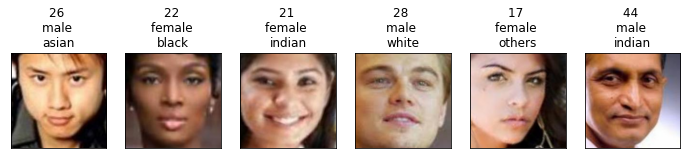

In [10]:
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(12, 9))
index = 0
for i in range(6):
    axes[i].set_title('{} \n{} \n{}'.
                      format(ages[index], 
                             gender_labels[genders[index]], 
                             race_labels[races[index]]))
    axes[i].imshow(images[index])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    index += 1
plt.show()

## Reshaping the labels (because in the next step we will perform horizontal stack)

In [11]:
ages = ages[:,np.newaxis]
genders = genders[:,np.newaxis]
races = races[:,np.newaxis]

In [12]:
ages.shape

(23705, 1)

In [13]:
ages

array([[26],
       [22],
       [21],
       ...,
       [ 2],
       [65],
       [66]])

In [14]:
ages.shape

(23705, 1)

## Now all the labels are stored in targets array (every single row stores age, gender and race respectively)

In [15]:
targets = np.hstack((ages, genders, races))
targets

array([[26,  0,  2],
       [22,  1,  1],
       [21,  1,  3],
       ...,
       [ 2,  0,  2],
       [65,  1,  0],
       [66,  0,  1]])

## Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, 
                                                    test_size=0.2, 
                                                    random_state=99)

In [17]:
print('X_train.shape\t:', X_train.shape)
print('X_test.shape\t:', X_test.shape)
print('y_train.shape\t:', y_train.shape)
print('y_test.shape\t:', y_test.shape)

X_train.shape	: (18964, 200, 200, 3)
X_test.shape	: (4741, 200, 200, 3)
y_train.shape	: (18964, 3)
y_test.shape	: (4741, 3)


## Split the labels (since we will transform the gender into one hot format)

In [18]:
y_train_age = y_train[:,0]
y_train_gender = y_train[:,1]
y_train_race = y_train[:,2]

y_test_age = y_test[:,0]
y_test_gender = y_test[:,1]
y_test_race = y_test[:,2]

In [19]:
y_train_race

array([3, 1, 0, ..., 3, 0, 1])

## Reshape the race labels

In [20]:
y_train_race = y_train_race[:,np.newaxis]
y_test_race = y_test_race[:,np.newaxis]

In [21]:
y_train_race

array([[3],
       [1],
       [0],
       ...,
       [3],
       [0],
       [1]])

## Transform the race labels into one hot

In [22]:
race_encoder = OneHotEncoder(sparse=False)
y_train_race_enc = race_encoder.fit_transform(y_train_race)
y_test_race_enc = race_encoder.transform(y_test_race)

## Create the multi-output CNN

In [23]:
tf.random.set_seed(999)

# Main
input1 = Input(shape=(200,200,3))
main = Conv2D(16, (3,3), padding='same')(input1)
main = BatchNormalization()(main)
main = MaxPool2D((3,3))(main)
main = BatchNormalization()(main)
main = Conv2D(32, (3,3), padding='same')(main)
main = BatchNormalization()(main)
main = MaxPool2D((3,3))(main)
main = BatchNormalization()(main)

In [24]:
age = Conv2D(64, (3,3), padding='same')(main)
age = BatchNormalization()(age)
age = MaxPool2D((3,3))(age)
age = BatchNormalization()(age)
age = Flatten()(age)
age = Dense(128, activation='relu')(age)
age = BatchNormalization()(age)
age = Dense(1, activation='linear', name='age')(age)

In [25]:
gender = Conv2D(64, (3,3), padding='same')(main)
gender = BatchNormalization()(gender)
gender = MaxPool2D((3,3))(gender)
gender = BatchNormalization()(gender)
gender = Flatten()(gender)
gender = Dense(128, activation='relu')(gender)
gender = BatchNormalization()(gender)
gender = Dense(1, activation='sigmoid', name='gender')(gender)

In [26]:
race = Conv2D(64, (3,3), padding='same')(main)
race = BatchNormalization()(race)
race = MaxPool2D((3,3))(race)
race = BatchNormalization()(race)
race = Flatten()(race)
race = Dense(128, activation='relu')(race)
race = BatchNormalization()(race)
race = Dense(5, activation='softmax', name='race')(race)

In [27]:
model = Model(input1, [age, gender, race])

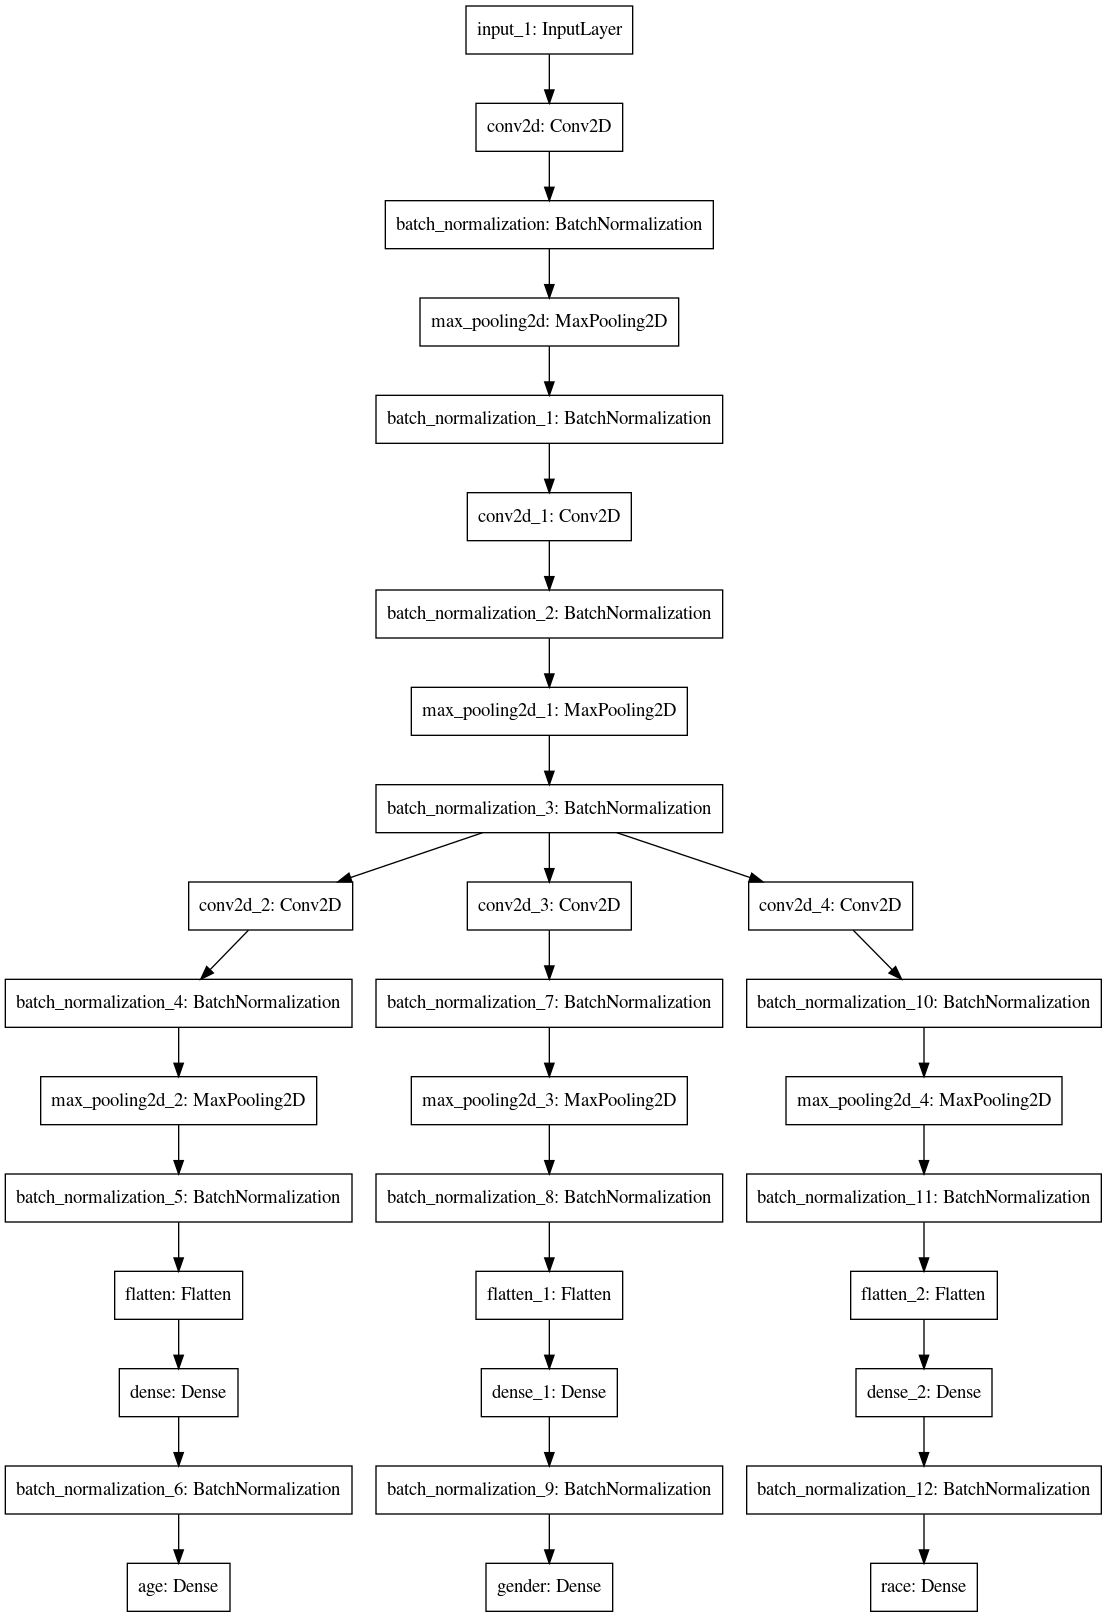

In [28]:
plot_model(model, to_file='cnn.png')

In [29]:
opt = Adam(lr=1e-4, decay=1e-6)

model.compile(optimizer=opt, 
              loss={
                  'age':'mse',
                  'gender':'binary_crossentropy', 
                  'race':'categorical_crossentropy', 
              }, 
              metrics={
                  'age':'mae',
                  'gender':'accuracy', 
                  'race':'accuracy', 
              })

In [30]:
y_train_list = ([y_train_age, y_train_gender, y_train_race_enc])
y_test_list = ([y_test_age, y_test_gender, y_test_race_enc])

history = model.fit(X_train, y_train_list, 
                    epochs=20, batch_size=64,
                    validation_data=(X_test, y_test_list))

Epoch 1/20
297/297 [==============================] - 16s 37ms/step - loss: 1370.1912 - age_loss: 1368.3597 - gender_loss: 0.4702 - race_loss: 1.3611 - age_mae: 33.1920 - gender_accuracy: 0.7789 - race_accuracy: 0.5125 - val_loss: 1184.1031 - val_age_loss: 1182.8982 - val_gender_loss: 0.3733 - val_race_loss: 0.8317 - val_age_mae: 32.0765 - val_gender_accuracy: 0.8372 - val_race_accuracy: 0.7180
Epoch 2/20
297/297 [==============================] - 10s 34ms/step - loss: 1195.2703 - age_loss: 1194.2175 - gender_loss: 0.2801 - race_loss: 0.7725 - age_mae: 32.4842 - gender_accuracy: 0.8830 - race_accuracy: 0.7429 - val_loss: 1086.3591 - val_age_loss: 1085.3616 - val_gender_loss: 0.2798 - val_race_loss: 0.7179 - val_age_mae: 31.0589 - val_gender_accuracy: 0.8857 - val_race_accuracy: 0.7553
Epoch 3/20
297/297 [==============================] - 10s 33ms/step - loss: 1119.3632 - age_loss: 1118.4733 - gender_loss: 0.2413 - race_loss: 0.6483 - age_mae: 31.7160 - gender_accuracy: 0.9051 - race_ac

## Training history

Text(0.5, 1.0, 'Age MAE')

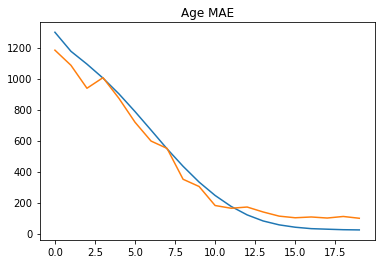

In [31]:
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('Age MAE')

Text(0.5, 1.0, 'Gender Accuracy')

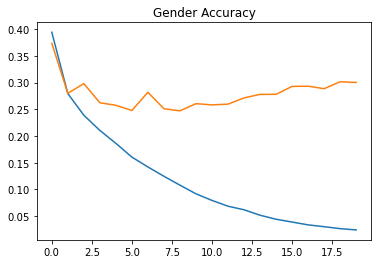

In [32]:
plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.title('Gender Accuracy')

Text(0.5, 1.0, 'Race Accuracy')

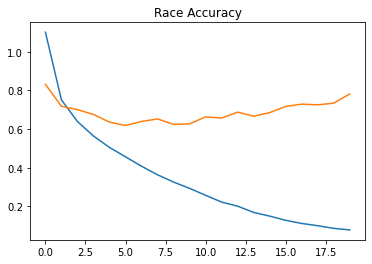

In [33]:
plt.plot(history.history['race_loss'])
plt.plot(history.history['val_race_loss'])
plt.title('Race Accuracy')

## Predicting several test data

In [34]:
predictions = model.predict(X_test[:12])

In [35]:
predictions

[array([[16.541069 ],
        [16.539774 ],
        [32.670753 ],
        [39.642014 ],
        [ 3.6352432],
        [26.60206  ],
        [33.947464 ],
        [ 9.422826 ],
        [45.419262 ],
        [30.977924 ],
        [40.05703  ],
        [18.703054 ]], dtype=float32),
 array([[9.1545242e-01],
        [9.9887747e-01],
        [9.9217775e-04],
        [2.8415783e-03],
        [7.3462629e-01],
        [9.7918814e-01],
        [1.5306146e-03],
        [2.1759216e-01],
        [1.3584472e-01],
        [4.0604758e-05],
        [3.7523976e-01],
        [9.6930951e-01]], dtype=float32),
 array([[4.0014234e-01, 1.8837865e-01, 3.0135933e-02, 3.3895490e-01,
         4.2388119e-02],
        [9.7504741e-01, 2.8822056e-03, 2.6238238e-05, 4.1219145e-03,
         1.7922265e-02],
        [9.9120694e-01, 1.6450100e-03, 7.4601194e-05, 3.3889106e-03,
         3.6844416e-03],
        [9.7282547e-01, 2.6692742e-02, 1.2887277e-04, 5.7210509e-05,
         2.9565624e-04],
        [3.0575209e-06, 6.

In [36]:
age_preds = predictions[0].flatten()
age_preds

array([16.541069 , 16.539774 , 32.670753 , 39.642014 ,  3.6352432,
       26.60206  , 33.947464 ,  9.422826 , 45.419262 , 30.977924 ,
       40.05703  , 18.703054 ], dtype=float32)

In [37]:
age_preds = np.round(age_preds).astype(int)
age_preds

array([17, 17, 33, 40,  4, 27, 34,  9, 45, 31, 40, 19])

In [38]:
gender_preds = predictions[1].flatten()
gender_preds

array([9.1545242e-01, 9.9887747e-01, 9.9217775e-04, 2.8415783e-03,
       7.3462629e-01, 9.7918814e-01, 1.5306146e-03, 2.1759216e-01,
       1.3584472e-01, 4.0604758e-05, 3.7523976e-01, 9.6930951e-01],
      dtype=float32)

In [39]:
gender_preds = np.round(gender_preds).astype(int)
gender_preds

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1])

In [40]:
race_preds = predictions[2]
race_preds

array([[4.0014234e-01, 1.8837865e-01, 3.0135933e-02, 3.3895490e-01,
        4.2388119e-02],
       [9.7504741e-01, 2.8822056e-03, 2.6238238e-05, 4.1219145e-03,
        1.7922265e-02],
       [9.9120694e-01, 1.6450100e-03, 7.4601194e-05, 3.3889106e-03,
        3.6844416e-03],
       [9.7282547e-01, 2.6692742e-02, 1.2887277e-04, 5.7210509e-05,
        2.9565624e-04],
       [3.0575209e-06, 6.1454364e-07, 9.9999559e-01, 3.3022707e-07,
        3.1862589e-07],
       [4.5404124e-01, 2.3709845e-02, 4.9069530e-01, 1.7155387e-02,
        1.4398184e-02],
       [9.7639990e-01, 9.8177115e-04, 7.6465978e-05, 1.2263282e-03,
        2.1315470e-02],
       [5.7626812e-04, 1.2278105e-06, 9.9923646e-01, 9.8761404e-08,
        1.8597841e-04],
       [7.9463498e-04, 4.2413335e-02, 6.7304232e-04, 9.5539129e-01,
        7.2762673e-04],
       [5.4355955e-06, 4.4376713e-05, 2.2877786e-04, 9.9970251e-01,
        1.8784101e-05],
       [1.5748516e-01, 1.6565915e-04, 8.2767165e-01, 7.4008973e-03,
        7.27

In [41]:
race_preds = np.argmax(race_preds, axis=1)
race_preds

array([0, 0, 0, 0, 2, 2, 0, 2, 3, 3, 2, 0])

## Displaying the predicted images

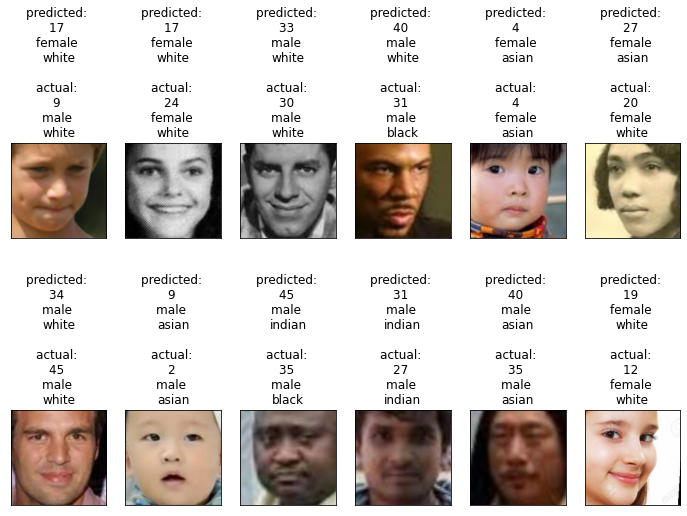

In [42]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(12, 9))
index = 0
for i in range(2):
    for j in range(6):
        axes[i,j].set_title('predicted: \n{} \n{} \n{}' \
                            '\n\n' \
                            'actual: \n{} \n{} \n{}'.
                            format(age_preds[index],
                                   gender_labels[gender_preds[index]],
                                   race_labels[race_preds[index]],
                                   y_test_age[index],
                                   gender_labels[y_test_gender[index]],
                                   race_labels[y_test_race[index][0]]))
        axes[i,j].imshow(X_test[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()